## Import libraries

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import ETFs as etfs

Total number of ETFs: 33


## Prepare the data

In [ ]:
tickers = etfs.etfs
today = pd.Timestamp.today().strftime('%Y-%m-%d')

start_date = "2012-01-01"
end_date = "2025-3-31"  #end date is not inclusive, so it will be until 3-28

data_download = yf.download(tickers=tickers, start = start_date, end = end_date)
# data_long = data_download.stack(level=1).reset_index()
# data_long.to_csv('assets.csv', index=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  33 of 33 completed


## Read CSV

In [3]:
data = pd.read_csv('assets_final.csv', parse_dates=['Date'])
print(data.columns.tolist())
data.set_index('Date', inplace=True)
display(data)


['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume']


,Ticker,Close,High,Low,Open,Volume
Date,,,,,,
2012-01-03,CORN,42.619999,42.990002,42.180000,42.730000,114100.0
2012-01-03,DBO,26.042213,26.094877,25.770118,25.796449,318300.0
2012-01-03,EWA,12.307325,12.368639,12.234864,12.240437,2787500.0
2012-01-03,EWC,20.625574,20.648157,20.384692,20.437385,6790400.0
2012-01-03,EWG,14.720881,14.838237,14.706211,14.742885,3892700.0
...,...,...,...,...,...,...
2025-03-28,VDNR.L,136.095001,138.505005,136.065002,137.910004,31820.0
2025-03-28,VGK,70.980003,71.260002,70.820000,71.190002,6081100.0
2025-03-28,VNQ,89.709999,90.279999,89.129997,90.120003,3602900.0


In [4]:
data_close = data[['Ticker', 'Close']].copy()
display(data_close)

,Ticker,Close
Date,,
2012-01-03,CORN,42.619999
2012-01-03,DBO,26.042213
2012-01-03,EWA,12.307325
2012-01-03,EWC,20.625574
2012-01-03,EWG,14.720881
...,...,...
2025-03-28,VDNR.L,136.095001
2025-03-28,VGK,70.980003
2025-03-28,VNQ,89.709999


## Prepare the data with only the name and Close price 

In [5]:
data_close = data[['Ticker', 'Close']].copy()
# data_close[data_close['Ticker'] == 'SPY']['Close'].plot()
data_close['Yesterday'] = data_close.groupby('Ticker')['Close'].shift(1)
data_close['Target'] = (data_close['Close'] > data_close['Yesterday']).astype(int)
# data_close.dropna(inplace=True)
display(data_close[data_close['Ticker'] == 'SPY'])


,Ticker,Close,Yesterday,Target
Date,,,,
2012-01-03,SPY,100.450676,NaN,0
2012-01-04,SPY,100.608253,100.450676,1
2012-01-05,SPY,100.876114,100.608253,1
2012-01-06,SPY,100.616119,100.876114,0
2012-01-09,SPY,100.860352,100.616119,1
...,...,...,...,...
2025-03-24,SPY,574.080017,563.979980,1
2025-03-25,SPY,575.460022,574.080017,1
2025-03-26,SPY,568.590027,575.460022,0


## Change the dataframe pivot as the columns are each ticker's closing prices

In [6]:
close_wide = data_close.pivot(columns='Ticker', values='Close')
close_wide = close_wide.fillna(-1)
# close_wide.dropna(inplace=True)
display(close_wide)

Ticker,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,-1.000000,-1.000,-1.000000,42.619999,26.042213,-1.000000,-1.000000,12.307325,20.625574,14.720881,...,28.830000,100.450676,83.888611,317.519989,69.905632,-1.000000,27.664732,34.591938,33.707809,6.78375
2012-01-04,-1.000000,-1.000,-1.000000,42.509998,26.165096,-1.000000,-1.000000,12.452251,20.587931,14.581521,...,28.389999,100.608253,82.891129,318.160004,70.114960,-1.000000,27.328690,34.000526,33.888023,6.69750
2012-01-05,-1.000000,-1.000,-1.000000,41.509998,25.814005,-1.000000,-1.000000,12.290603,20.459967,14.412822,...,28.510000,100.876114,82.743683,313.359985,69.817871,-1.000000,26.831108,34.319893,33.472149,6.68250
2012-01-06,-1.000000,-1.000,-1.000000,41.349998,25.919333,-1.000000,-1.000000,12.128961,20.249195,14.148769,...,27.910000,100.616119,83.396896,313.760010,69.392525,-1.000000,26.462761,34.207516,33.070122,6.72625
2012-01-09,-1.000000,-1.000,-1.000000,42.189999,25.831560,-1.000000,-1.000000,12.167976,20.309412,14.207450,...,28.129999,100.860352,83.249367,312.640015,69.655846,-1.000000,26.663080,34.089233,33.097851,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [7]:
target_wide = (close_wide > close_wide.shift(1)).astype(int)
display(target_wide)

Ticker,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-04,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,1,0,0,0,1,0
2012-01-05,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
2012-01-06,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
2012-01-09,0,0,0,1,0,0,0,1,1,1,...,1,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


## Test data correctness

In [8]:
test_df = pd.DataFrame({'Close_yesterday': close_wide['SPY'].shift(1),'Close Tody':close_wide['SPY'],'Target': target_wide['SPY']})
display(test_df)

,Close_yesterday,Close Tody,Target
Date,,,
2012-01-03,NaN,100.450676,0
2012-01-04,100.450676,100.608253,1
2012-01-05,100.608253,100.876114,1
2012-01-06,100.876114,100.616119,0
2012-01-09,100.616119,100.860352,1
...,...,...,...
2025-03-24,563.979980,574.080017,1
2025-03-25,574.080017,575.460022,1
2025-03-26,575.460022,568.590027,0


## Drop out NaN data

In [9]:
close_wide = close_wide.iloc[1:]
target_wide = target_wide.iloc[1:]

display(close_wide)
display(target_wide)


Ticker,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-1.000000,-1.000,-1.000000,42.509998,26.165096,-1.000000,-1.000000,12.452251,20.587931,14.581521,...,28.389999,100.608253,82.891129,318.160004,70.114960,-1.000000,27.328690,34.000526,33.888023,6.69750
2012-01-05,-1.000000,-1.000,-1.000000,41.509998,25.814005,-1.000000,-1.000000,12.290603,20.459967,14.412822,...,28.510000,100.876114,82.743683,313.359985,69.817871,-1.000000,26.831108,34.319893,33.472149,6.68250
2012-01-06,-1.000000,-1.000,-1.000000,41.349998,25.919333,-1.000000,-1.000000,12.128961,20.249195,14.148769,...,27.910000,100.616119,83.396896,313.760010,69.392525,-1.000000,26.462761,34.207516,33.070122,6.72625
2012-01-09,-1.000000,-1.000,-1.000000,42.189999,25.831560,-1.000000,-1.000000,12.167976,20.309412,14.207450,...,28.129999,100.860352,83.249367,312.640015,69.655846,-1.000000,26.663080,34.089233,33.097851,6.69625
2012-01-10,-1.000000,-1.000,-1.000000,42.049999,25.963217,-1.000000,-1.000000,12.402084,20.572880,14.464169,...,29.049999,101.734871,83.108910,314.720001,70.256721,-1.000000,27.070200,34.467743,33.610767,6.81750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


Ticker,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,1,0,0,0,1,0
2012-01-05,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
2012-01-06,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
2012-01-09,0,0,0,1,0,0,0,1,1,1,...,1,1,0,0,1,0,1,0,1,0
2012-01-10,0,0,0,0,1,0,0,1,1,1,...,1,1,0,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


## Normalize the data by dividing the Initial price

In [10]:
first_prices = close_wide.apply(
    lambda col: col[col != -1].iloc[0] if (col != -1).any() else np.nan
)
first_prices_df = first_prices.to_frame().T
first_prices_df.index = ['First Price']  
display(first_prices_df)


normalized_close = close_wide / first_prices

normalized_close = normalized_close.mask(close_wide < 0, -1) 

normalized_array = normalized_close.to_numpy(dtype='float32')

print(f"normalized_array.shape {normalized_array.shape}")
print(f"normalized_array {normalized_array}")
display(normalized_close)

Ticker,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
First Price,21.902443,6.246624,40.0,42.509998,26.165096,22.380074,42.757011,12.452251,20.587931,14.581521,...,28.389999,100.608253,82.891129,318.160004,70.11496,42.300945,27.32869,34.000526,33.888023,6.6975


normalized_array.shape (3407, 33)
normalized_array [[-1.        -1.        -1.        ...  1.         1.         1.       ]
 [-1.        -1.        -1.        ...  1.009393   0.987728   0.9977603]
 [-1.        -1.        -1.        ...  1.0060878  0.9758646  1.0042926]
 ...
 [ 1.7283003  1.6648993  2.4542499 ...  2.6487825  2.1957612  1.2161255]
 [ 1.7193516  1.6745046  2.427     ...  2.642018   2.1934004  1.2030607]
 [ 1.6822325  1.6552943  2.317875  ...  2.6384885  2.1541533  1.2099664]]


Ticker,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000
2012-01-05,-1.000000,-1.000000,-1.000000,0.976476,0.986582,-1.000000,-1.000000,0.987019,0.993785,0.988431,...,1.004227,1.002662,0.998221,0.984913,0.995763,-1.000000,0.981793,1.009393,0.987728,0.997760
2012-01-06,-1.000000,-1.000000,-1.000000,0.972712,0.990607,-1.000000,-1.000000,0.974038,0.983547,0.970322,...,0.983093,1.000078,1.006102,0.986170,0.989696,-1.000000,0.968314,1.006088,0.975865,1.004293
2012-01-09,-1.000000,-1.000000,-1.000000,0.992472,0.987253,-1.000000,-1.000000,0.977171,0.986472,0.974346,...,0.990842,1.002506,1.004322,0.982650,0.993452,-1.000000,0.975644,1.002609,0.976683,0.999813
2012-01-10,-1.000000,-1.000000,-1.000000,0.989179,0.992284,-1.000000,-1.000000,0.995971,0.999269,0.991952,...,1.023248,1.011198,1.002627,0.989188,1.002022,-1.000000,0.990541,1.013741,0.991818,1.017917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1.747568,1.665700,2.513750,0.445307,0.540415,4.822594,1.321187,1.903270,2.016230,2.608095,...,1.055301,5.706093,1.071165,0.235353,1.840278,3.316002,2.624714,2.668429,2.204024,1.237402
2025-03-25,1.752316,1.671303,2.518000,0.441543,0.536211,4.795784,1.323292,1.912104,2.025944,2.632099,...,1.077140,5.719809,1.071045,0.235165,1.846396,3.320966,2.640449,2.638489,2.215827,1.216685
2025-03-26,1.728300,1.664899,2.454250,0.436603,0.539268,4.729207,1.311598,1.904073,2.009916,2.575863,...,1.075379,5.651525,1.064005,0.237051,1.857663,3.300044,2.603125,2.648782,2.195761,1.216125


In [11]:
index_series = pd.Series(normalized_close.index)
index_series

0      2012-01-04
1      2012-01-05
2      2012-01-06
3      2012-01-09
4      2012-01-10
          ...    
3402   2025-03-24
3403   2025-03-25
3404   2025-03-26
3405   2025-03-27
3406   2025-03-28
Name: Date, Length: 3407, dtype: datetime64[ns]

## Create the data by every 30 days as window size, then each window will be created as matrix

### So the X will be 30 days closing prices, and y is 31th price, and then rolling forward
### and so y has size of length of data - window size

In [12]:
def create_X_y(feature, target, window_size):
    X, y = [], []
    for i in range(len(feature) - window_size):
        X.append(feature[i : i + window_size])
    for i in range(len(target) - window_size):
        y.append(target[i + window_size])
    return np.array(X), np.array(y)
window_size = 30
target_wide_array = target_wide.to_numpy(dtype='float32')
display(normalized_close.shape)
display(target_wide_array.shape)
X, y = create_X_y(normalized_close, target_wide_array, window_size)
print(X.shape)
print(y.shape)
# display(X)

(3407, 33)

(3407, 33)

(3377, 30, 33)
(3377, 33)


## Train the model

In [13]:
dataset_size = len(X)
print(dataset_size)
train_size = int(dataset_size * 0.8)
test_size = 30
val_size = dataset_size - train_size - 30


X_train, X_val, X_test = X[:train_size], X[train_size: train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test= y[:train_size], y[train_size: train_size + val_size], y[train_size + val_size:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


3377


((2701, 30, 33), (2701, 33), (646, 30, 33), (646, 33), (30, 30, 33), (30, 33))

In [14]:
print(np.unique(y_train))  # Should print [0. 1.]
print(y_train.dtype)       # Should be float32 or float64


[0. 1.]
float32


<Axes: title={'center': 'Ratio of 1s in y_train'}>

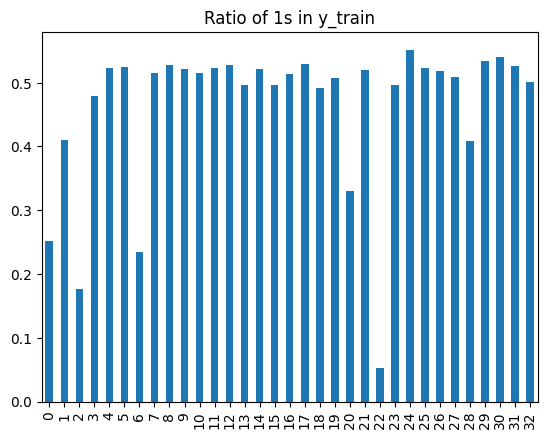

In [15]:
pd.DataFrame(y_train).mean().plot(kind='bar', title='Ratio of 1s in y_train')


In [16]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(y_train.shape[1], activation='sigmoid')
])

cp = ModelCheckpoint(filepath='model/best_binary.keras', 
                     save_best_only=True, monitor='val_loss', 
                     mode='min')

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001),   
              metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',        # Watch validation loss
    patience=5,                # Stop if no improvement for 5 epochs
    restore_best_weights=True # Roll back to the best model weights
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[cp, early_stop]
)
# model.summary()




c:\Users\Shelly\Desktop\KU\18_Bachelor project\venv_project\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.0149 - loss: 0.6464 - val_accuracy: 0.0046 - val_loss: 0.7031
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0249 - loss: 0.6275 - val_accuracy: 0.2879 - val_loss: 0.7021
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.0246 - loss: 0.6132 - val_accuracy: 0.5232 - val_loss: 0.7016
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.0355 - loss: 0.6048 - val_accuracy: 0.0573 - val_loss: 0.7006
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0459 - loss: 0.6005 - val_accuracy: 0.3111 - val_loss: 0.6986
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0174 - loss: 0.6004 - val_accuracy: 0.3189 - val_loss: 0.6992
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.0167 - loss: 0.5960 - val_accuracy: 0.0913 - val_loss: 0.6944
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0344 - loss: 0.5941 - val_accuracy: 0.0975 - v

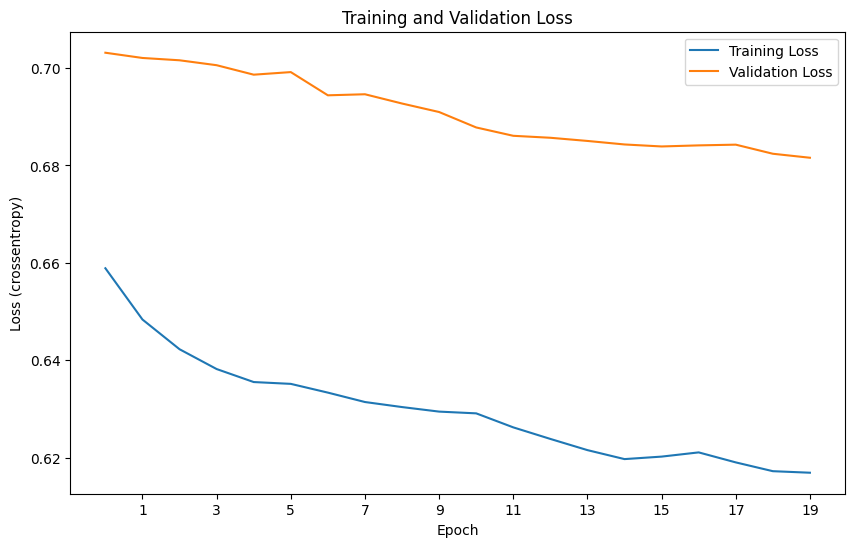

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (crossentropy)')
plt.legend()
xticks = np.arange(1, 21, 2)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Flatten predictions and ground truth
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

print("F1:", f1_score(y_val.flatten(), y_val_pred_binary.flatten()))
print("Precision:", precision_score(y_val.flatten(), y_val_pred_binary.flatten()))
print("Recall:", recall_score(y_val.flatten(), y_val_pred_binary.flatten()))


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
F1: 0.5480651374540361
Precision: 0.5262273032952253
Recall: 0.5717939349652905


## Predictions

In [ ]:
model = load_model('model/best_binary.keras')
y_pred = model.predict(X_test)
y_pred_mean = y_pred.mean(axis=0)
y_pred_classes = (y_pred_mean > 0.6).astype(int)

y_pred_df = pd.DataFrame(y_pred_classes, index=target_wide.columns)
display(y_pred_df)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


,0
Ticker,
AIEQ,0
ASHR.L,0
BCHN.L,0
CORN,0
DBO,0
EDEN,0
EMXC,0
EWA,0
EWC,0


In [23]:
# today_target_true = target_wide.iloc[-1]
# today_target_predicted = y_pred_df.iloc[-1]
# from sklearn.metrics import accuracy_score
# print("Binary accuracy:", accuracy_score(today_target_true, today_target_predicted))

### Accuracy

In [24]:
yesterday_prices = close_wide.iloc[-2]  # second last row 

today_prices_actual = close_wide.iloc[-1] # last row

today_taget_predicted = pd.Series(y_pred_classes.flatten(), index=target_wide.columns)

today_target_true = target_wide.iloc[-1] 

comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_actual_target': today_target_true,
    'Today_pred_target': today_taget_predicted,
})

tickers_names = target_wide.columns

correct_list = []
for ticker in tickers_names:
    predict = today_taget_predicted[ticker]
    actual = today_target_true[ticker]
    if predict == actual:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list

count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
# display(comparison_df)
save_df = pd.DataFrame()
save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
save_df['Today actual target'] = comparison_df['Today_actual_target'].apply(lambda x: round(x, 2))
save_df['Today pred target'] = comparison_df['Today_pred_target'].apply(lambda x: round(x, 2))
save_df['Correct'] = comparison_df['Correct']
display(save_df)
save_df.to_csv('rnn_binary_6.csv', index=False)


Count of correct predictions: 30
accuracy: 0.9090909090909091


,Yesterday actual,Today actual,Today actual target,Today pred target,Correct
Ticker,,,,,
AIEQ,37.66,36.85,0,0,1
ASHR.L,10.46,10.34,0,0,1
BCHN.L,97.08,92.71,0,0,1
CORN,18.51,18.46,0,0,1
DBO,14.13,13.97,0,0,1
EDEN,105.33,105.17,0,0,1
EMXC,56.11,55.18,0,0,1
EWA,23.75,23.47,0,0,1
EWC,41.25,40.57,0,0,1
